In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/home/mdafifal.mamun/notebooks/triagerX/data/openj9/openj9_bug_data.csv")

In [3]:
from sklearn.model_selection import train_test_split
from loguru import logger

test_size=0.1

df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df.sort_values(by="issue_number")
df = df[df["owner"].notna()]

num_issues = len(df)
logger.info(f"Total number of issues after processing: {num_issues}")

df = df.sort_values(by="issue_number")

df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

unwanted = list(test_owners - train_owners)

df_test = df_test[~df_test["owner"].isin(unwanted)]

logger.info(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
logger.info(f"Number of developers: {len(df_train.owner.unique())}")

logger.info(f"Train dataset size: {len(df_train)}")
logger.info(f"Test dataset size: {len(df_test)}")

2024-08-04 14:28:09.613 | INFO     | __main__:<module>:11 - Total number of issues after processing: 4510
2024-08-04 14:28:09.619 | INFO     | __main__:<module>:29 - Training data: 3323, Validation data: 379
2024-08-04 14:28:09.621 | INFO     | __main__:<module>:30 - Number of developers: 50
2024-08-04 14:28:09.622 | INFO     | __main__:<module>:32 - Train dataset size: 3323
2024-08-04 14:28:09.624 | INFO     | __main__:<module>:33 - Test dataset size: 379


In [4]:
df_train.owner.value_counts()

owner
JasonFengJ9            320
pshipton               301
keithc-ca              238
babsingh               199
hangshao0              106
dsouzai                100
gacholio                99
llxia                   95
knn-k                   90
ChengJin01              89
fjeremic                86
fengxue-IS              84
a7ehuo                  79
tajila                  76
pdbain-ibm              70
mpirvu                  70
AdamBrousseau           67
smlambert               62
hzongaro                60
DanHeidinga             57
harryyu1994             55
mikezhang1234567890     55
dmitry-ten              52
theresa-m               50
yanluo7                 44
LongyuZhang             40
jdmpapin                39
Mesbah-Alam             39
0dvictor                37
LinHu2016               34
jdekonin                33
BradleyWood             33
r30shah                 30
AlenBadel               30
dmitripivkine           30
ymanton                 29
thallium              

In [5]:
lbl2idx = {}
idx2lbl = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx
    idx2lbl[idx] = dev

df_train["owner_id"] = df_train["owner"].apply(lambda owner: lbl2idx[owner])
df_test["owner_id"] = df_test["owner"].apply(lambda owner: lbl2idx[owner])

In [6]:
import numpy as np

In [7]:
class_counts = np.bincount(df_train["owner_id"])
num_samples = sum(class_counts)
labels = df_train["owner_id"].to_list()  # corresponding labels of samples

class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]

In [8]:
import torch

In [9]:
class_counts = torch.bincount(torch.tensor(labels))
total_samples = len(labels)

# Calculate class weights (inverse of class frequency)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = class_weights.float()

In [10]:
target = df_train.owner_id

In [11]:
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])

In [12]:
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

In [13]:
samples_weight

array([0.01428571, 0.03333333, 0.01666667, ..., 0.02564103, 0.00502513,
       0.01      ])

In [14]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Example dataset and weights
data = [1, 2, 3, 4, 5, 6]
labels = [0, 0, 1, 1, 1, 1]  # Imbalanced classes
weights = [0.1, 0.1, 0.2, 0.3, 0.3, 0.3]  # Sample weights

class_sample_count = np.array(
    [len(np.where(labels == t)[0]) for t in np.unique(labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])

# Create sampler with replacement
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=False)

# Create DataLoader with sampler
data_loader = DataLoader(data, sampler=sampler, batch_size=5)

# Iterate over DataLoader
for batch in data_loader:
    print(batch)

tensor([5, 4, 3, 1, 6])
tensor([2])


In [15]:
class_weights

tensor([1.7962, 3.3230, 0.9919, 2.8896, 2.2153, 2.0139, 0.7467, 1.1660, 2.6584,
        2.4615, 0.2077, 1.9547, 1.6615, 1.7041, 0.8413, 2.7692, 2.5562, 0.3340,
        2.7692, 3.0209, 2.2153, 1.2781, 2.7692, 0.6646, 0.7912, 0.7728, 0.6713,
        2.7692, 0.6270, 1.2084, 1.1077, 2.0139, 1.7041, 0.2792, 0.7384, 2.6584,
        0.6996, 1.2084, 0.9494, 2.4615, 0.9494, 0.2208, 2.2153, 2.5562, 1.0719,
        0.8745, 2.3736, 1.3292, 1.5105, 2.2917])

In [16]:
class_counts

tensor([ 37,  20,  67,  23,  30,  33,  89,  57,  25,  27, 320,  34,  40,  39,
         79,  24,  26, 199,  24,  22,  30,  52,  24, 100,  84,  86,  99,  24,
        106,  55,  60,  33,  39, 238,  90,  25,  95,  55,  70,  27,  70, 301,
         30,  26,  62,  76,  28,  50,  44,  29])

In [17]:
from transformers import AutoTokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-large")

In [19]:
tokenizer.decode([38500])

'554'

In [20]:
tokenizer("1582275888554")

{'input_ids': [1, 26758, 2036, 2545, 22410, 38500, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [21]:
special_tokens = {"additional_special_tokens": ["<time>"]}
tokenizer.add_special_tokens(special_tokens)

tokenizer.add_special_tokens(special_tokens)

0

In [22]:
tokenizer("01:40:14")

{'input_ids': [1, 2663, 35, 1749, 35, 1570, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [23]:
from triagerx.model.module_factory import DatasetFactory, ModelFactory

In [24]:
gg = ModelFactory.get_model(
    model_key="triagerx",
    output_size=1032,
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-base", "roberta-base"],
    dropout=0.2,
    max_tokens=256,
    label_map={},
)

2024-08-04 14:28:12.686 | DEBUG    | triagerx.model.module_factory:get_model:60 - Instantiating model of class: <class 'triagerx.model.triagerx_model.TriagerxModel'>
2024-08-04 14:28:12.688 | DEBUG    | triagerx.model.module_factory:get_model:71 - Including number of filters and classifiers
2024-08-04 14:28:12.689 | DEBUG    | triagerx.model.triagerx_model:__init__:24 - Loading base transformer models: ['microsoft/deberta-base', 'roberta-base']
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-08-04 14:28:15.941 | DEBUG    | triagerx.model.triagerx_model:__init__:41 - Freezing 9 layers
2024-08-04 14:28:15.944 | DEBUG    | triagerx.model.triagerx_model:__init__:41 - Freezing 9 layers


In [25]:
yy = ModelFactory.get_model(
    model_key="cnn-transformer",
    output_size=1032,
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-large"],
    dropout=0.2,
    max_tokens=256,
    label_map={},
)

2024-08-04 14:28:16.105 | DEBUG    | triagerx.model.module_factory:get_model:60 - Instantiating model of class: <class 'triagerx.model.cnn_transformer.CNNTransformer'>
2024-08-04 14:28:16.107 | DEBUG    | triagerx.model.module_factory:get_model:71 - Including number of filters and classifiers
2024-08-04 14:28:17.194 | DEBUG    | triagerx.model.cnn_transformer:__init__:31 - Freezing 21 layers


In [26]:
total_params = sum(p.numel() for p in gg.parameters())

total_params2 = sum(p.numel() for p in yy.parameters())

In [27]:
total_params - total_params2

-134837751

In [28]:
print(total_params, total_params2)

287663649 422501400


In [29]:
(total_params2 - total_params) / total_params2

0.3191415484067035

In [30]:
import pandas as pd

In [31]:
df = pd.read_csv("notebook/orthogonality.csv")

In [32]:
df = df[["Step", "cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc", "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", "cnn_deberta-base_u3_50_classes_most_seed42 - val_acc"]]

In [33]:
df2 = pd.read_csv("notebook/c1-c3.csv")

In [34]:
df2 = df2[["Step", "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", "openj9_triagerx_ensemble_u2c2_50_classes_last_dev_seed42 - val_acc", "openj9_triagerx_ensemble_u3c1_50_classes_last_dev_seed42 - val_acc"]]

In [35]:
from scipy.signal import savgol_filter

In [36]:
df["Step"] = df.Step.apply(lambda x: x + 1)

In [37]:
df2["Step"] = df2.Step.apply(lambda x: x + 1)

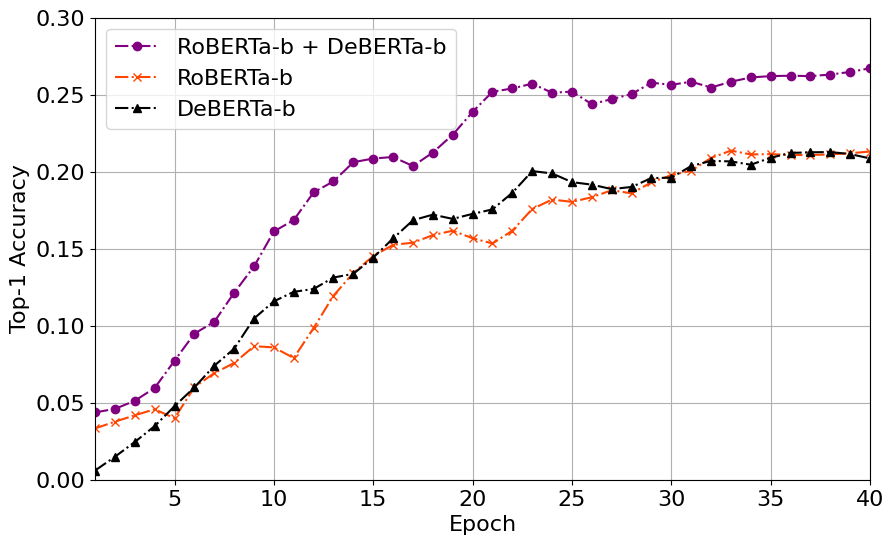

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Process the data (select columns)
epochs = df['Step']
u3c3 = savgol_filter(df['cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2 = savgol_filter(df['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u1c1 = savgol_filter(df['cnn_deberta-base_u3_50_classes_most_seed42 - val_acc'], window_length=7, polyorder=2)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, u2c2, linestyle='-.', color="purple", marker='o', label='RoBERTa-b + DeBERTa-b')
plt.plot(epochs, u3c3, linestyle='-.', color="orangered", marker='x', label='RoBERTa-b')
plt.plot(epochs, u1c1, linestyle='-.', color="black", marker='^', label='DeBERTa-b')

# Customize the plot
# plt.title('Top-1 Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
plt.legend(fontsize=16)  # Increase legend font size
plt.xlim(left=1, right=40)
plt.ylim(0, 0.3)
plt.legend(fontsize=16)
plt.grid(True)

plt.savefig('openj9-top-1.pdf', bbox_inches='tight', pad_inches=0)


# Show the plot
plt.show()

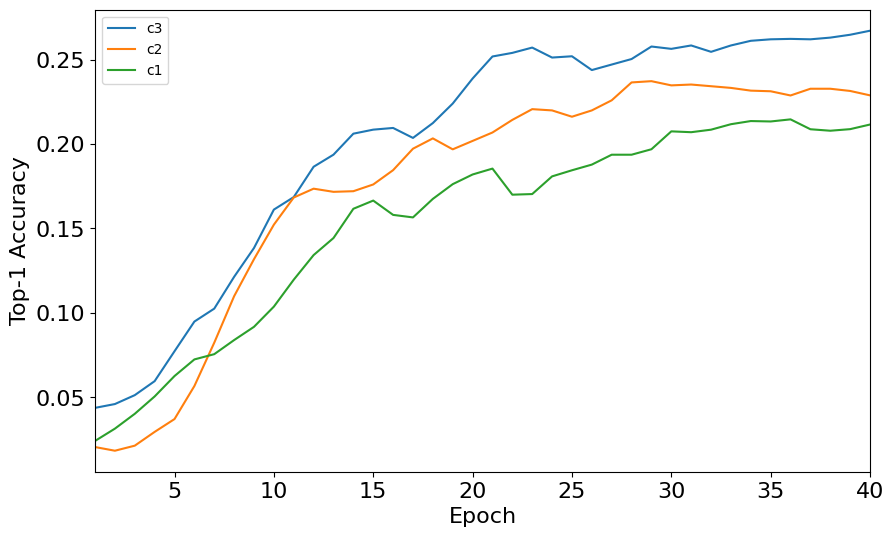

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# plt.rcParams["text.usetex"] = True

# Process the data (select columns)
epochs = df2['Step']
u3c3 = savgol_filter(df2['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2 = savgol_filter(df2['openj9_triagerx_ensemble_u2c2_50_classes_last_dev_seed42 - val_acc'] - 0.02, window_length=7, polyorder=2)
u1c1 = savgol_filter(df2['openj9_triagerx_ensemble_u3c1_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, u3c3, label='c3')
plt.plot(epochs, u2c2, label='c2')
plt.plot(epochs, u1c1, label='c1')

# Customize the plot
# plt.title('Top-1 Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
plt.legend(fontsize=16)  # Increase legend font size
plt.xlim(left=1, right=40)

plt.legend()
plt.grid(False)

plt.savefig('openj9-c1-c3.pdf', bbox_inches='tight', pad_inches=0)


# Show the plot
plt.show()

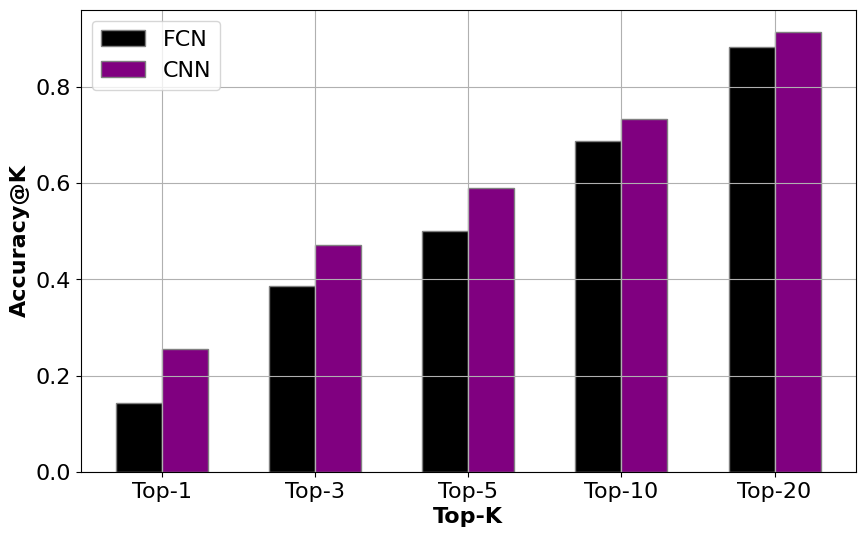

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False


# Data
methods = ['Top-1', 'Top-3', 'Top-5', 'Top-10', 'Top-20']
fcn_accuracies = [0.143, 0.387, 0.5, 0.688, 0.884]
cnn_accuracies = [0.256, 0.472, 0.591, 0.733, 0.915]

# Bar width
bar_width = 0.15

# Positions of the bars on the x-axis with reduced space between groups
r1 = np.arange(len(methods)) * 0.5
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(r1, fcn_accuracies, color='black', width=bar_width, edgecolor='gray', label='FCN')
plt.bar(r2, cnn_accuracies, color='purple', width=bar_width, edgecolor='gray', label='CNN')

# Adding labels and title
plt.xlabel('Top-K', fontweight='bold', fontsize=16)
plt.ylabel('Accuracy@K', fontweight='bold', fontsize=16)
# plt.title('Comparison of Top-k Accuracy: CNN vs. FCN', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in r1], methods, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

plt.savefig('cnn-vs-fcn.pdf', bbox_inches='tight', pad_inches=0)
# Show plot
plt.show()


In [41]:
def min_max_normalize(array):
    normalized_array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return normalized_array

In [42]:
x = np.array([0.143, 0.387, 0.5, 0.688, 0.884])
min_max_normalize(np.exp(x * -1))

array([1.        , 0.58630552, 0.42634935, 0.19719535, 0.        ])

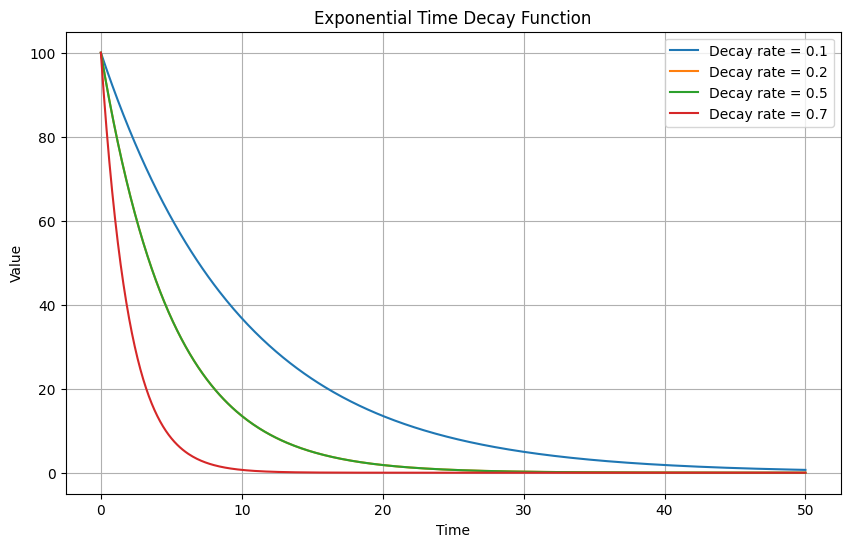

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_exponential_decay(initial_value, decay_rate, time_period):
    """
    Plots an exponential time decay function.
    
    Parameters:
    initial_value (float): The initial value at time t=0.
    decay_rate (float): The rate at which the value decays over time.
    time_period (int): The period over which to plot the decay (number of time units).
    """
    
    # Generate time values
    time_values = np.linspace(0, time_period, 500)
    
    # Calculate exponential decay values
    decay_values = initial_value * np.exp(-decay_rate * time_values)
    decay_values2 = initial_value * np.exp(-0.2 * time_values)
    decay_values3 = initial_value * np.exp(-0.5 * time_values)
    decay_values4 = initial_value * np.exp(-0.7 * time_values)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, decay_values, label=f'Decay rate = {decay_rate}')
    plt.plot(time_values, decay_values2, label=f'Decay rate = {0.2}')
    plt.plot(time_values, decay_values2, label=f'Decay rate = {0.5}')
    plt.plot(time_values, decay_values3, label=f'Decay rate = {0.7}')
    plt.title('Exponential Time Decay Function')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_exponential_decay(initial_value=100, decay_rate=0.1, time_period=50)


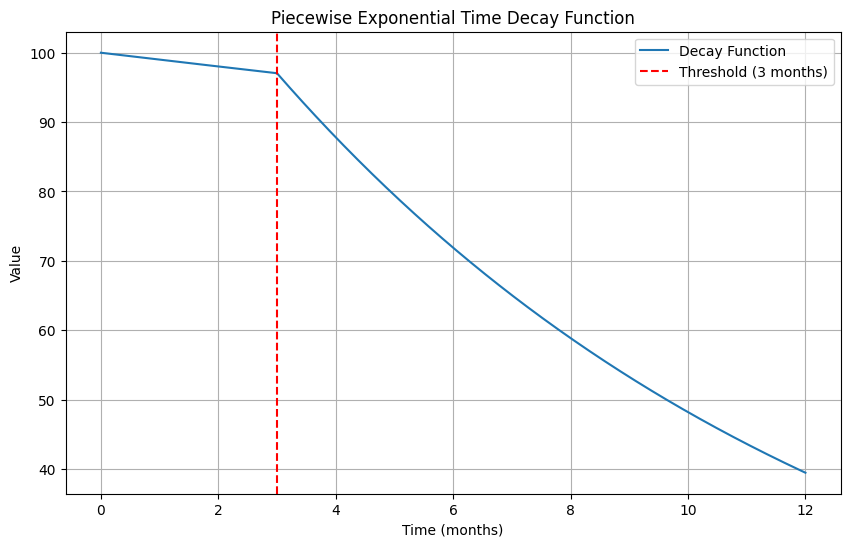

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

def months_since(date):
    current_date = datetime.now()
    difference = relativedelta(current_date, date)
    return difference.years * 12 + difference.months

def piecewise_decay_function(time, initial_value, slow_decay_rate, fast_decay_rate, threshold_months):
    decay_values = np.piecewise(
        time,
        [time <= threshold_months, time > threshold_months],
        [
            lambda t: initial_value * np.exp(-slow_decay_rate * t),
            lambda t: initial_value * np.exp(-slow_decay_rate * threshold_months) * np.exp(-fast_decay_rate * (t - threshold_months)),
        ]
    )
    return decay_values

def plot_piecewise_decay(initial_value, slow_decay_rate, fast_decay_rate, time_period, threshold_months):
    # Generate time values in months
    time_values = np.linspace(0, time_period, 500)
    
    # Calculate decay values using the piecewise decay function
    decay_values = piecewise_decay_function(time_values, initial_value, slow_decay_rate, fast_decay_rate, threshold_months)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, decay_values, label='Decay Function')
    plt.title('Piecewise Exponential Time Decay Function')
    plt.xlabel('Time (months)')
    plt.ylabel('Value')
    plt.axvline(x=threshold_months, color='r', linestyle='--', label='Threshold (3 months)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
initial_value = 100
slow_decay_rate = 0.01  # Slow decay rate within 3 months
fast_decay_rate = 0.1   # Fast decay rate after 3 months
time_period = 12        # Time period to plot (in months)
threshold_months = 3   # Threshold for switching decay rate (in months)

plot_piecewise_decay(initial_value, slow_decay_rate, fast_decay_rate, time_period, threshold_months)


In [45]:
import pandas as pd
time_factor_df = pd.read_csv("notebook/time_factor.csv")

In [46]:
time_factor_df = time_factor_df.sort_values(by="time_decay_factor", ascending=True)

In [47]:
time_factor_df

,similarity_prediction_weight,time_decay_factor,direct_assignment_score,contribution_score,discussion_score,similarity_threshold,topk_issues,T1DL,T1Sim,T1Com,...,T3Com,T5DL,T5Sim,T5Com,T10DL,T10Sim,T10Com,T20DL,T20Sim,T20Com
19,0.65,-0.10,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.110818,...,0.416887,0.591029,0.263852,0.556728,0.728232,0.514512,0.722955,0.899736,0.804749,0.889182
18,0.65,-0.09,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.110818,...,0.416887,0.591029,0.263852,0.556728,0.728232,0.517150,0.720317,0.899736,0.804749,0.889182
17,0.65,-0.08,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.110818,...,0.414248,0.591029,0.263852,0.554090,0.728232,0.519789,0.720317,0.899736,0.804749,0.889182
16,0.65,-0.07,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.110818,...,0.414248,0.591029,0.263852,0.554090,0.728232,0.517150,0.717678,0.899736,0.804749,0.889182
15,0.65,-0.06,0.5,1.5,0.2,0.5,20,0.255937,0.073879,0.113456,...,0.411609,0.591029,0.266491,0.556728,0.728232,0.519789,0.717678,0.899736,0.804749,0.889182
14,0.65,-0.05,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.113456,...,0.408971,0.591029,0.266491,0.562005,0.728232,0.519789,0.717678,0.899736,0.804749,0.889182
13,0.65,-0.04,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.108179,...,0.416887,0.591029,0.269129,0.562005,0.728232,0.525066,0.715040,0.899736,0.804749,0.889182
12,0.65,-0.03,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.113456,...,0.419525,0.591029,0.269129,0.556728,0.728232,0.527704,0.712401,0.899736,0.804749,0.889182
11,0.65,-0.02,0.5,1.5,0.2,0.5,20,0.255937,0.081794,0.116095,...,0.416887,0.591029,0.269129,0.551451,0.728232,0.530343,0.704485,0.899736,0.804749,0.886544
20,0.65,-0.01,0.5,1.5,0.2,0.5,20,0.255937,0.089710,0.129288,...,0.424802,0.591029,0.274406,0.551451,0.728232,0.530343,0.701847,0.899736,0.807388,0.886544


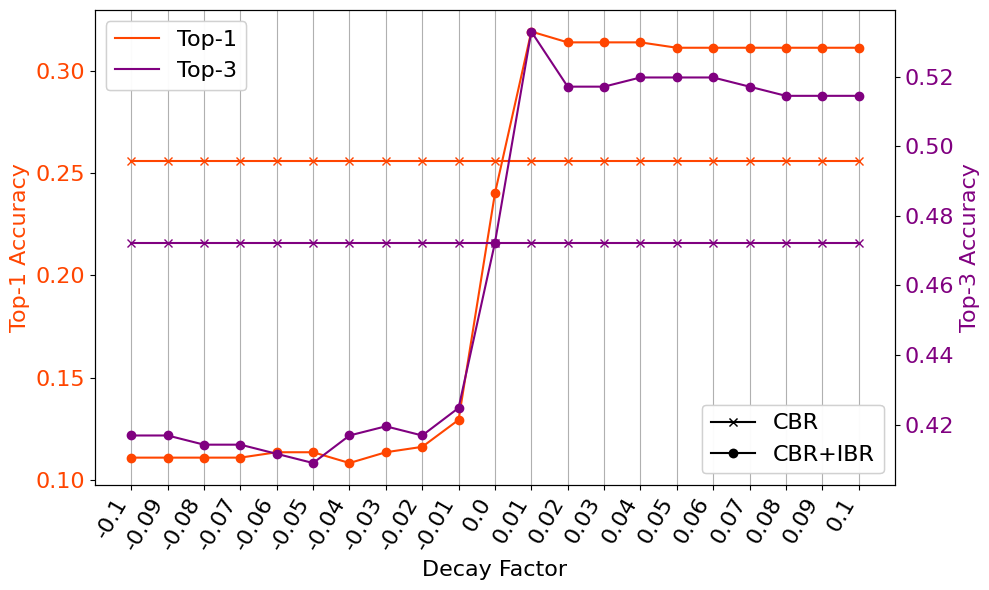

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Ensure you replace 'time_factor_df' with your actual DataFrame variable name
# Process the data (select columns)
time_factor = time_factor_df['time_decay_factor'].tolist()
t1dl = time_factor_df["T1DL"].tolist()
t1 = time_factor_df["T1Com"].tolist()
t3dl = time_factor_df["T3DL"].tolist()
t3 = time_factor_df["T3Com"].tolist()

# Set font preferences
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Top-1 accuracy on primary y-axis with different markers
ax1.plot(time_factor, t1, color='orangered', marker='o', label='Top-1')
ax1.plot(time_factor, t1dl, color='orangered', marker='x', label='Top-1DL')
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.set_ylabel('Top-1 Accuracy', fontsize=16, color='orangered')
ax1.tick_params(axis='y', labelcolor='orangered')

# Create a secondary y-axis for Top-3 accuracy with different markers
ax2 = ax1.twinx()
ax2.plot(time_factor, t3, color='purple', marker='o', label='Top-3')
ax2.plot(time_factor, t3dl, color='purple', marker='x', label='Top-3DL')
ax2.set_ylabel('Top-3 Accuracy', fontsize=16, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Customize the plot
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Set x-axis tick positions and labels
ax1.set_xticks(time_factor)
ax1.set_xticklabels([str(tf) for tf in time_factor], rotation=60, ha='right')

# Show only vertical grid lines
ax1.grid(True, axis='x')
ax1.grid(False, axis='y')

ax2.grid(False, axis='x')
ax2.grid(False, axis='y')

# Create proxy artists for the legends
top1_line = mlines.Line2D([], [], color='orangered', label='Top-1')
top3_line = mlines.Line2D([], [], color='purple', label='Top-3')
cbr_line = mlines.Line2D([], [], color='black', marker='x', label='CBR')
cbr_cob_line = mlines.Line2D([], [], color='black', marker='o', label='CBR+IBR')

# Create legends for each set of markers separately
legend1 = ax1.legend(handles=[top1_line, top3_line], loc='upper left', fontsize=16)
legend2 = ax2.legend(handles=[cbr_line, cbr_cob_line], loc='lower right', fontsize=16)

# Add the legends to the plot
ax1.add_artist(legend1)
ax2.add_artist(legend2)

# Adjust layout and save/show the plot
plt.tight_layout()

plt.savefig('openj9-decay-factor.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [49]:
import json
with open("notebook/top1_class_comparison.json", "r") as f:
    json_data = json.load(f)

In [50]:
correct_pred = json_data["y_true"]
roberta_pred = json_data["roberta_pred"]
deberta_pred = json_data["deberta_pred"]
triagerx_pred = json_data["triagerx_cbr"]

index = [idx for idx, target in enumerate(correct_pred) if target in [2, 8, 10, 15, 20, 25, 30, 35, 40, 23, 27, 30, 41, 38]]

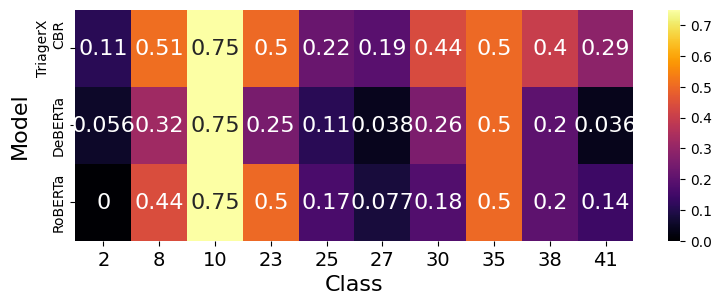

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Example true labels and predictions for three models
y_true = np.array(correct_pred)[index]
y_pred_model1 = np.array(triagerx_pred)[index]
y_pred_model2 = np.array(roberta_pred)[index]
y_pred_model3 = np.array(deberta_pred)[index]

# Unique classes
classes = np.unique(y_true)

# Calculate correct predictions for each model and each class
def count_correct_predictions(y_true, y_pred, classes):
    correct_counts = []
    for cls in classes:
        correct_counts.append(np.sum((y_true == cls) & (y_true == y_pred)))
    return correct_counts

correct_model1 = count_correct_predictions(y_true, y_pred_model1, classes)
correct_model2 = count_correct_predictions(y_true, y_pred_model2, classes)
correct_model3 = count_correct_predictions(y_true, y_pred_model3, classes)

# Calculate total correct truths for each class
total_correct = np.array([np.sum(y_true == cls) for cls in classes])

# Normalize correct predictions by total correct truths for each class
normalized_correct_model1 = np.array(correct_model1) / total_correct
normalized_correct_model2 = np.array(correct_model2) / total_correct
normalized_correct_model3 = np.array(correct_model3) / total_correct

# Combine the normalized correct predictions into a single array for heatmap
normalized_correct_predictions = np.array([normalized_correct_model1, normalized_correct_model2, normalized_correct_model3])

# Create a heatmap
plt.figure(figsize=(9, 3))
ax = sns.heatmap(normalized_correct_predictions, annot=True, cmap='inferno', xticklabels=classes, yticklabels=['TriagerX\nCBR', 'DeBERTa', 'RoBERTa'], annot_kws={"size": 16})
# plt.title('Class-wise comparison of top-1 accuracy on Openj9 dataset.', f)
plt.xlabel('Class', fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=16)
# ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Model', fontsize=16)
plt.savefig('openj9-top1-classwise.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [52]:
models = ["TriagerX CBR", "RoBERTa-l (FCN)", "RoBERTa-l (CNN)", "DeBERTa-l (FCN)", "DeBERTa-l (CNN)"]
parameters = [271.33, 356.37, 361.09, 407.22, 410.89]
top1_accuracy = [0.327, 0.267, 0.247, 0.285, 0.251] 

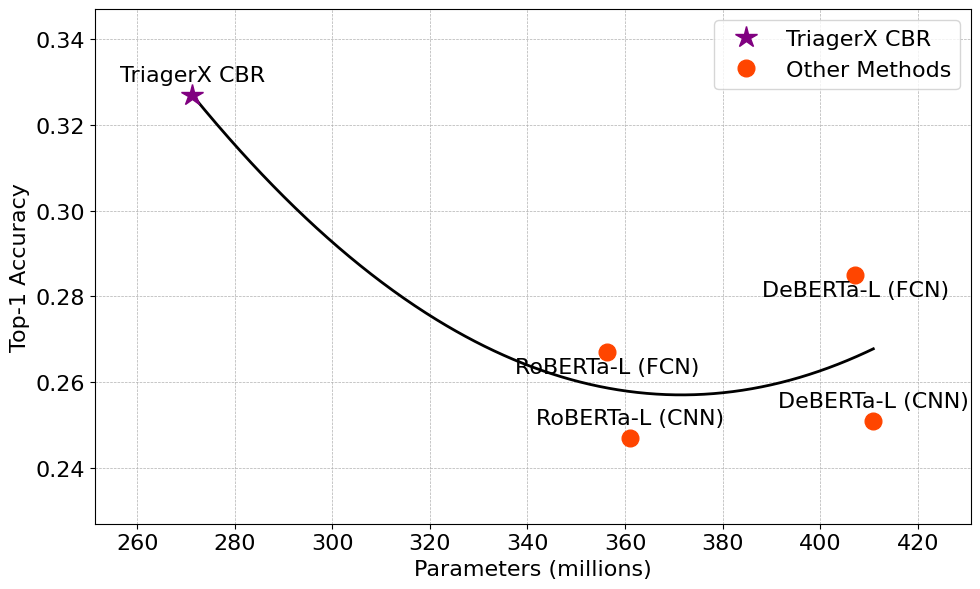

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Set plot font and style preferences
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Data
models = ["TriagerX CBR", "RoBERTa-L (FCN)", "RoBERTa-L (CNN)", "DeBERTa-L (FCN)", "DeBERTa-L (CNN)"]
parameters = [271.33, 356.37, 361.09, 407.22, 410.89]
top1_accuracy = [0.327, 0.267, 0.247, 0.285, 0.251]

# Fit a polynomial curve
z = np.polyfit(parameters, top1_accuracy, 2)
p = np.poly1d(z)

# Generate values for a smooth curve
x_smooth = np.linspace(min(parameters), max(parameters), 500)
y_smooth = p(x_smooth)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the polynomial fit line
ax.plot(x_smooth, y_smooth, '-', color='black', linewidth=2)

# Plot the markers for the data points
ax.plot(parameters[0], top1_accuracy[0], marker='*', color='purple', linestyle='None', markersize=16, label='TriagerX CBR')
ax.plot(parameters[1:], top1_accuracy[1:], marker='o', color='orangered', linestyle='None', markersize=12, label='Other Methods')

# Annotate each point with the model name
for i, model in enumerate(models):
    offset = 10 if i % 2 == 0 else -15  # Adjust offset to avoid overlap
    ax.annotate(model, (parameters[i], top1_accuracy[i]), textcoords="offset points", xytext=(0, offset), ha='center', fontsize=16)

# Set labels and title
ax.set_xlabel('Parameters (millions)', fontsize=16)
ax.set_ylabel('Top-1 Accuracy', fontsize=16)

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the axis limits
ax.set_xlim(min(parameters) - 20, max(parameters) + 20)
ax.set_ylim(min(top1_accuracy) - 0.02, max(top1_accuracy) + 0.02)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.tick_params(axis='x', rotation=45) # Uncomment if you want rotated x-axis labels

# Add a legend
ax.legend(loc='best', fontsize=16)

plt.savefig('acc-vs-params.pdf', bbox_inches='tight', pad_inches=0)

# plt.grid(False)
# Show plot
plt.tight_layout()
plt.show()


In [54]:
sim_df = pd.read_csv("notebook/similarity_threshold.csv")
sim_df = sim_df.sort_values(by="similarity_threshold")

In [55]:
similarity_threshold = sim_df["similarity_threshold"]
top1_accuracy = sim_df["T1Com"]

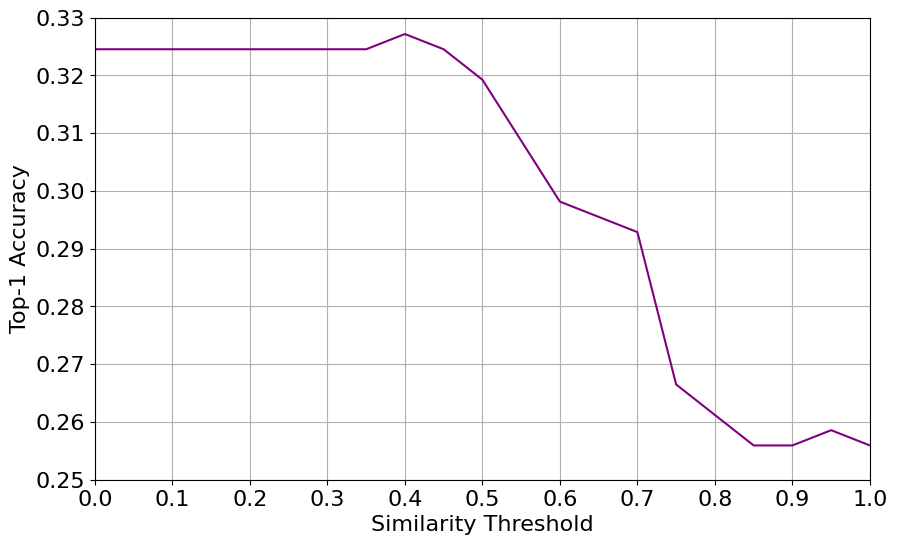

In [56]:
import matplotlib.pyplot as plt

# Assuming sim_df is a DataFrame containing your data
similarity_threshold = sim_df["similarity_threshold"]
top1_accuracy = sim_df["T1Com"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(similarity_threshold, top1_accuracy, linestyle='-', color='purple')

# Add title and labels
plt.xlabel('Similarity Threshold', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)

# Set x-ticks and x-axis limits
plt.xticks([i/10 for i in range(11)], fontsize=16)  # Ticks from 0.0 to 1.0 with 0.1 interval
plt.xlim(0, 1)
plt.ylim(0.25, 0.33)

# Show grid
plt.tick_params(labelsize=16)
plt.grid(True)

# Save the plot
plt.savefig('top1-vs-threshold.pdf', bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

def plot_token_attributions_combined(attributions_model1, attributions_model2, tokens_model1, tokens_model2, output_file='saliency_text_highlight.png'):
    """
    Generates and saves a plot with tokens highlighted based on their attribution intensity
    from two different models, using different color maps for easy comparison.

    Args:
        attributions_model1 (np.array): The summed attributions for each token from the first model.
        attributions_model2 (np.array): The summed attributions for each token from the second model.
        tokens_model1 (list of str): All tokens in the input text for the first model.
        tokens_model2 (list of str): All tokens in the input text for the second model.
        output_file (str): The file path to save the plot.
    """
    # Plot attributions with bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Adjust x and y tick font size and font family
    plt.xticks(fontname='serif', fontsize=16)
    plt.yticks(fontname='serif', fontsize=16)
    
    # First model attributes
    cmap1 = plt.cm.coolwarm
    norm1 = plt.Normalize(attributions_model1.min(), attributions_model1.max())
    bars1 = ax.bar(range(len(tokens_model1)), attributions_model1[:len(tokens_model1)], color="purple", alpha=0.7, label='TriagerX')
    
    # Second model attributes
    cmap2 = plt.cm.viridis
    norm2 = plt.Normalize(attributions_model2.min(), attributions_model2.max())
    bars2 = ax.bar(range(len(tokens_model2)), attributions_model2[:len(tokens_model2)], color="orangered", alpha=0.7, label='LBT-P')

    # Set x-ticks and labels
    ax.set_xticks(range(max(len(tokens_model1), len(tokens_model2))))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xticklabels(tokens_model1, rotation=90)
    ax.set_xlabel('Tokens', fontname='serif', fontsize=16)
    ax.set_ylabel('Attribution', fontname='serif', fontsize=16)
    ax.legend()
    
    # # Add color bars
    # cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap1, norm=norm1), ax=ax, fraction=0.01, pad=0.02)
    # cbar1.ax.tick_params(labelsize=8)
    # cbar1.set_label('Model 1 Attribution Intensity', fontname='serif', fontsize=10)
    
    # cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2, norm=norm2), ax=ax, fraction=0.01, pad=0.08)
    # cbar2.ax.tick_params(labelsize=8)
    # cbar2.set_label('Model 2 Attribution Intensity', fontname='serif', fontsize=10)

    # Save the plot as an image file
    plt.grid(False)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()


In [58]:
import json

json_file = json.load(open("notebook/token_attribution.json", "r"))

In [59]:
triagerx_tokens_attr = json_file["trx_token_attr"]
lbtp_tokens_attr = json_file["lbtp_token_attr"]
triagerx_tokens = json_file["trx_tokens"]
lbtp_tokens = json_file["lbtp_tokens"]

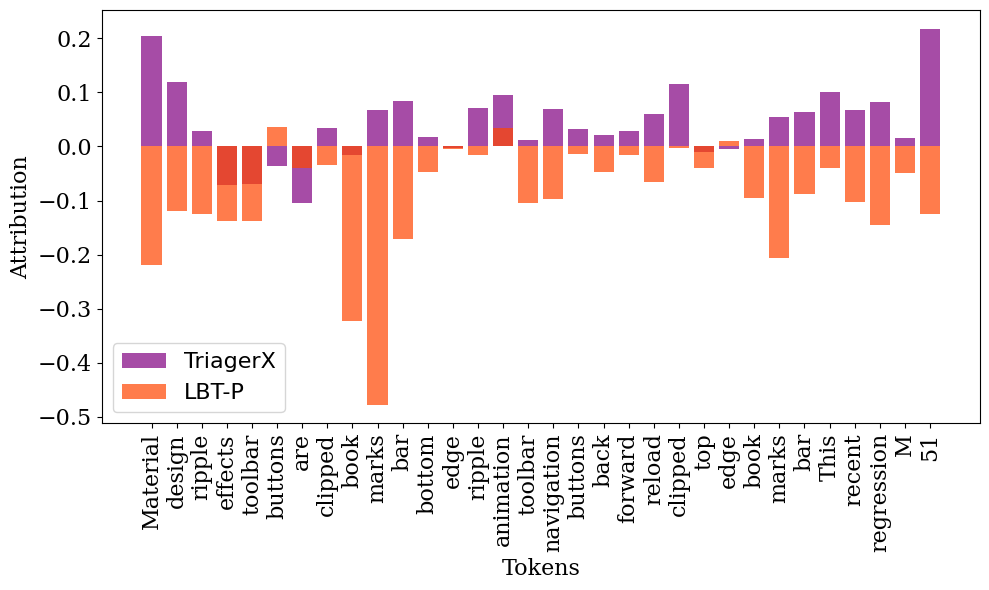

In [60]:
plot_token_attributions_combined(np.array(triagerx_tokens_attr), np.array(lbtp_tokens_attr), triagerx_tokens, lbtp_tokens, "saliency_combined.pdf")